## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import datetime
import json

## Loading Data

In [2]:
path = r'C:\Users\Alessio\Downloads\Takeout\Chrome\BrowserHistory.json'

with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)

history = data['Browser History']
df = pd.DataFrame(history)
df.drop(['favicon_url', 'page_transition', 'client_id'], axis=1, inplace=True)

## Preprocessing

In [3]:
# Convert microseconds to seconds
df['time_sec'] = df['time_usec'] / 1e6

# Create a datetime object from the seconds value
df['date_time'] = df['time_sec'].apply(lambda x: datetime.datetime.fromtimestamp(x))

# Format the date as a string
df['date_string'] = df['date_time'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))


# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date_string'])

# Extract additional time-based features
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()
df['week_number'] = df['date'].dt.isocalendar().week

df.drop(['time_usec', 'time_sec', 'date_time'], axis=1, inplace=True)

## Analysis

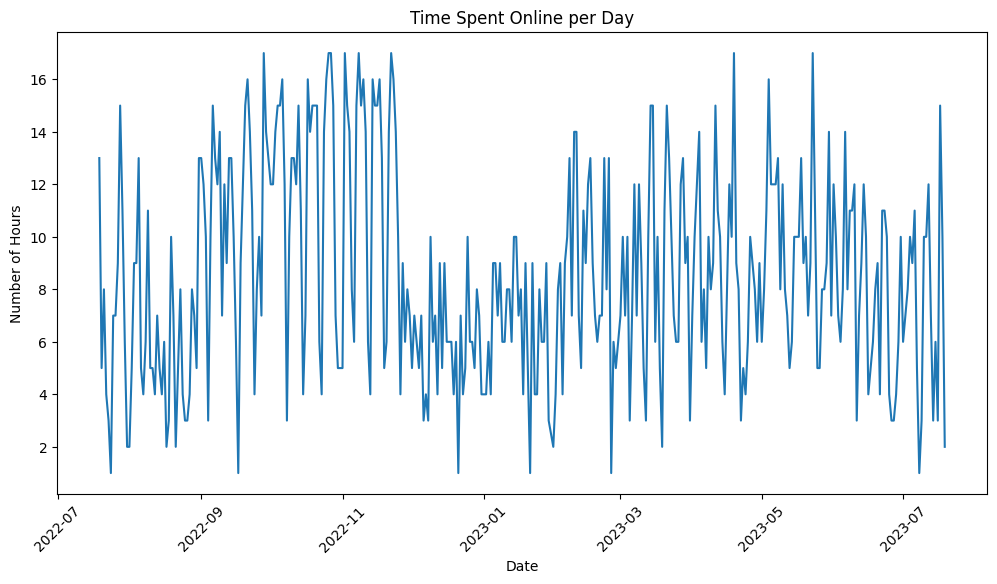

In [4]:
# Calculate time spent online (in hours) per day
time_spent_per_day = df.groupby(df['date'].dt.date)['hour'].nunique()

plt.figure(figsize=(12, 6))
# sns.barplot(x=time_spent_per_day.index, y=time_spent_per_day.values)
sns.lineplot(x=time_spent_per_day.index, y=time_spent_per_day.values)
plt.xlabel('Date')
plt.ylabel('Number of Hours')
plt.title('Time Spent Online per Day')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Extract domain from URLs
def extract_domain(url):
    match = re.search(r'(?P<domain>https?://)?(?P<subdomain>[\w.-]+)\.\w+', url)
    if match:
        return match.group('subdomain')
    else:
        # Return the full URL as the domain if the domain extraction fails
        return url

df['domain'] = df['url'].apply(extract_domain)

# Group data by domain and date, and count the number of visits
webpage_visits = df.groupby(['domain', df['date'].dt.date])['url'].count().reset_index()
webpage_visits.rename(columns={'url': 'visits'}, inplace=True)

In [6]:
df.drop(df[df['domain'] == 'chrome://newtab/'].index, axis=0, inplace=True)
df.drop(df[df['domain'] == 'chrome-native://newtab/'].index, axis=0, inplace=True)
df.drop(df[df['domain'] == 'mail.google'].index, axis=0, inplace=True)

In [7]:
# Most visited urls by day of the week
most_visited_url_by_day = df.groupby(['day_of_week', 'url'])['url'].count().groupby(level=0, group_keys=False).nlargest(1)

# Most visited urls by hour
most_visited_url_by_hour = df.groupby(['hour', 'url'])['url'].count().groupby(level=0, group_keys=False).nlargest(1)

# Most visited urls by week
most_visited_url_by_week = df.groupby(['week_number', 'url'])['url'].count().groupby(level=0, group_keys=False).nlargest(1)



# Most visited domains by day of the week
most_visited_domain_by_day = df.groupby(['day_of_week', 'domain'])['domain'].count().groupby(level=0, group_keys=False).nlargest(1)

# Most visited domains by hour
most_visited_domain_by_hour = df.groupby(['hour', 'domain'])['domain'].count().groupby(level=0, group_keys=False).nlargest(1)

# Most visited domains by week
most_visited_domain_by_week = df.groupby(['week_number', 'domain'])['domain'].count().groupby(level=0, group_keys=False).nlargest(1)

In [8]:
df.to_csv(r'./chrome_history.csv', index=False)

## Basic NLP with SKLearn

NLP and URL classification:
For NLP and URL classification, you can use natural language processing techniques. For example, you can tokenize the titles, remove stop words, perform stemming, and use machine learning models for classification.

In [ ]:
# Tokenize titles
nltk.download('punkt')
df['title_tokens'] = df['title'].apply(nltk.word_tokenize)

# Remove stop words and perform stemming
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) & set(stopwords.words('italian'))
ps = PorterStemmer()

def process_text(tokens):
    return [ps.stem(token.lower()) for token in tokens if token.lower() not in stop_words]

df['processed_text'] = df['title_tokens'].apply(process_text)

Clustering webpages viewed by hour:
For clustering webpages viewed by the hour, you can use algorithms like K-Means clustering after encoding the URLs.

In [ ]:
# Encoding URLs for clustering
# ... (Use one-hot encoding, count vectorization, or other suitable techniques)

# Apply K-Means clustering
# ... (Use your preferred clustering library and determine the number of clusters)

# Analyze the clusters and visualize the results
# ... (Based on the clustering results, find insights into webpages viewed by hour)

Q: Could you show me how to code a NLP algorithm or LLM algorithm that can tell me how a person behaved online in a certain range of hour of a certain day?

A:  I'll show you an example of how to use a simple NLP algorithm (bag-of-words model) to analyze a person's online behavior within a certain range of hours on a specific day.

NLP algorithm to analyze online behavior:
For this example, we'll use a simple bag-of-words model combined with Logistic Regression for classification. This will allow us to analyze the person's online behavior by predicting whether a certain webpage title represents a specific behavior category.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume you have a labeled dataset for training the model, containing 'title' and 'behavior' columns.
# The 'behavior' column will have categories like 'news', 'entertainment', 'education', etc.
# Here's a toy example:

training_data = pd.DataFrame({
    'title': ['Breaking News', 'Learn Python Online', 'Funny Cat Videos', 'Latest Tech Trends'],
    'behavior': ['news', 'education', 'entertainment', 'technology']
})

# Bag-of-words model
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(training_data['title'])
y = training_data['behavior']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict behavior based on webpage titles
X_new = vectorizer.transform(df['title'])
df['predicted_behavior'] = model.predict(X_new)

## LLM

### With Fine-Tuning

Q: How could I implement an open source LLM in order to ask questions about this dataframe?

A: Implementing a full-scale Language Model like GPT-3 (LLM stands for Large Language Model) from scratch would be an enormous and complex task, beyond the scope of a simple coding project. However, you can use pre-trained language models like GPT-2 or GPT-3, which are open-source and readily available for use.

Hugging Face's "transformers" library provides an easy-to-use interface for working with pre-trained language models, including GPT-2 and GPT-3. Below, I'll show you how to use GPT-2, as it's open-source and doesn't require API access like GPT-3.

First, you'll need to install the "transformers" library: pip install transformers

Next, you can use GPT-2 to ask questions about your DataFrame by fine-tuning it on a question-answering dataset that includes context and corresponding questions.

Prepare a question-answering dataset:
Create a dataset where each entry includes a context (information from your DataFrame) and a corresponding question about that context.
Example dataset (you can create a more extensive dataset):

In [ ]:
qa_dataset = [
    {
        'context': 'On July 19, 2023, I spent 2 hours online searching for information about Python programming. I visited websites like python.org and realpython.com.',
        'question': 'How many hours did I spend online on July 19, 2023?'
    },
    {
        'context': 'On July 19, 2023, I spent 2 hours online searching for information about Python programming. I visited websites like python.org and realpython.com.',
        'question': 'What websites did I visit on July 19, 2023?'
    },
    # Add more entries/questions as needed
]

Fine-tune GPT-2 on the dataset:
Fine-tune GPT-2 on the question-answering dataset using the "transformers" library.

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForQuestionAnswering
import torch

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2ForQuestionAnswering.from_pretrained(model_name)

# Fine-tune the model on your question-answering dataset
train_inputs = tokenizer([example['question'] + " " + example['context'] for example in qa_dataset],
                         padding=True,
                         truncation=True,
                         return_tensors='pt')
train_labels = tokenizer([example['context'] for example in qa_dataset],
                         padding=True,
                         truncation=True,
                         return_tensors='pt')

train_dataset = torch.utils.data.TensorDataset(train_inputs['input_ids'],
                                               train_inputs['attention_mask'],
                                               train_labels['input_ids'],
                                               train_labels['attention_mask'])

# Define the fine-tuning function
def fine_tune_model(model, train_dataset):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

    # Fine-tuning parameters
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    num_epochs = 5

    # Fine-tune the model
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            input_ids, attention_mask, labels, _ = batch
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

# Fine-tune the model
fine_tune_model(model, train_dataset)

Use the fine-tuned model for question-answering on your DataFrame:
With the fine-tuned model, you can now ask questions about the data in your DataFrame.

In [ ]:
# Assuming you have a DataFrame 'df' with columns 'context' and 'question':
def ask_questions(df, model, tokenizer):
    answers = []
    for index, row in df.iterrows():
        input_text = row['question'] + " " + row['context']
        inputs = tokenizer(input_text, return_tensors="pt")
        outputs = model(**inputs)
        answer_start = torch.argmax(outputs.start_logits)
        answer_end = torch.argmax(outputs.end_logits)
        answer = tokenizer.decode(inputs["input_ids"][0][answer_start:answer_end+1])
        answers.append(answer)
    return answers

# Example usage:
df['answer'] = ask_questions(df, model, tokenizer)

### Without Fine-Tuning

Q: Thank you. How could I use a LLM without needing to fine tune it? I don't have a dataset, only the dataframe containing the urls and the webpage names.

A: If you don't have a dataset for fine-tuning and you want to use a pre-trained LLM (Large Language Model) like GPT-2 or GPT-3 without additional fine-tuning, you can use a method called "zero-shot learning" or "few-shot learning." This approach allows you to leverage the capabilities of the pre-trained model to answer questions or generate text without needing a specific dataset for your task.

For this example, let's use GPT-2 as it doesn't require API access like GPT-3. We will use the transformers library, which provides a user-friendly interface for interacting with pre-trained models.

First, you'll need to install the "transformers" library if you haven't already: pip install transformers

Next, you can use GPT-2 to answer questions about your DataFrame without fine-tuning.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Function to generate answers using GPT-2
def generate_answer(question, model, tokenizer):
    input_text = question #+ " " + context
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(input_ids, max_length=200, num_return_sequences=1)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Example usage:
question = "How did I spend my evenings in the last four months, meaning from April to today?"
# context = "On July 19, 2023, I spent 2 hours online searching for information about Python programming. I visited websites like python.org and realpython.com."

# answer = generate_answer(question, context, model, tokenizer)
answer = generate_answer(question, model, tokenizer)
print("Generated Answer:", answer)

The generate_answer function will take a question and context (information from your DataFrame) as input and generate an answer using GPT-2. Keep in mind that GPT-2's responses are generated based on its pre-trained knowledge, and the quality of the generated answers may vary depending on the input context and the question.

Without fine-tuning, the model's responses are not specifically tailored to your dataset, and the accuracy of the answers might not be as high as with fine-tuning. However, GPT-2's language modeling capabilities can still provide useful insights and generate coherent responses based on the input data.

Remember that GPT-2's answers are generated based on the patterns it has learned during pre-training and may not be entirely accurate or contextually correct for all questions. Fine-tuning the model with your specific dataset would be a more robust approach for tailored answers.

### Without Fine-Tuning and Context

To use a pre-trained LLM (Large Language Model) like GPT-2 to ask questions about your DataFrame without fine-tuning, you can follow these steps:

Load the pre-trained LLM model and tokenizer.
Prepare a prompt or question based on the information you want to inquire about in your DataFrame.
Concatenate the prompt with specific details from your DataFrame to form the input text for the LLM.
Generate answers using the LLM.
Here's a step-by-step implementation:

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Function to generate answers using the LLM
def generate_answer(dataframe, question, model, tokenizer):
    answers = []
    for index, row in dataframe.iterrows():
        # Concatenate the question with specific details from the DataFrame
        prompt = question + " " + row['title'] + " " + row['url'] + " " + row['date_string']
        
        # Encode the input text and generate response
        input_ids = tokenizer.encode(prompt, return_tensors="pt")
        outputs = model.generate(input_ids, max_length=200, num_return_sequences=1)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Append the generated answer to the list
        answers.append(generated_text)
    return answers

# Example usage:
question = "What I did in the evenings of the last four months?"
# dataframe = pd.DataFrame(...)  # Your DataFrame with columns 'title', 'URL', and 'date'
dataframe = df[['title', 'url', 'date_string', 'day_of_week', 'domain']]
generated_answers = generate_answer(dataframe, question, model, tokenizer)

# Print the generated answers
for i, answer in enumerate(generated_answers):
    print(f"Answer {i+1}: {answer}")

In this implementation, the generate_answer function iterates through each row in your DataFrame and concatenates the question with specific details from each row to form the prompt. Then, it encodes the prompt using the LLM tokenizer and generates a response using the LLM model.

Please note that the quality of the generated answers may vary based on the information in your DataFrame and the LLM's pre-trained knowledge. Additionally, GPT-2's responses are generated based on patterns in the data it was trained on and might not always be contextually accurate or relevant.

Keep in mind that the LLM's capabilities are limited to the patterns it has learned during pre-training and might not provide perfect answers for all types of questions. If you need more precise answers or higher accuracy, you might consider fine-tuning the LLM on a specific dataset relevant to your task.

## LLM with LangChain

Questa parte l'ho ripresa dal file <code>falcon40Binstruct.ipynb</code> del progetto LLMApp

In [9]:
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import os 
import torch

c:\Users\Alessio\Documents\PyProjects\.LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Check if cuda is available 
torch.cuda.is_available()

False

In [ ]:
# Define Model ID
model_id = "tiiuae/falcon-40b-instruct"
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Load Model 
model = AutoModelForCausalLM.from_pretrained(model_id, cache_dir='./workspace/', 
    torch_dtype=torch.bfloat16, trust_remote_code=True, device_map="auto", offload_folder="offload")
# Set PT model to inference mode
model.eval()
# Build HF Transformers pipeline 
pipeline = transformers.pipeline(
    "text-generation", 
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_length=400,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id
)

In [ ]:
# Test out the pipeline
pipeline('who is kim kardashian?')

In [ ]:
# Setup prompt template
template = PromptTemplate(input_variables=['input'], template='{input}') 
# Pass hugging face pipeline to langchain class
llm = HuggingFacePipeline(pipeline=pipeline)
# Build stacked LLM chain i.e. prompt-formatting + LLM
chain = LLMChain(llm=llm, prompt=template)

In [ ]:
# Test LLMChain 
response = chain.run('who is kim kardashian?')